In [1]:
#@title Install Dependencies
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !pip install -q gymnasium
    !pip install moviepy
    !apt install ffmpeg
    !pip install imageio-ffmpeg
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
bash: ../xvfb: No such file or directory


# OpenAI Gym

OpenAI Gym, often referred to as "Gym", is a toolkit for developing and comparing RL algorithms. Gym provides a collection of environments with a standardized interface, making it easy for researchers and developers to experiment with and evaluate different RL algorithms. These environments cover a wide range of tasks, from simple toy problems to complex simulations and they allow users to develop and test their RL agents without having to implement the environment themselves. The toolkit is widely used in the field of ML and RL for experimentation and benchmarking purposes.

# Classic Control Environments

CartPole is part of [Classic Control Environments](https://www.gymlibrary.dev/environments/classic_control/), which include five classic control environments, i.e. Acrobot, CartPole, Mountain Car, Continuous Mountain Car, and Pendulum. You can access that first link for general information. Among Gym environments, this set of environments is among the easiest to be solved by a policy.  

# CartPole Environment

This environment corresponds to the version of Michie and Chambers' pole balancing problem, e.g. [Barto, Sutton, and Anderson (1983)](https://ieeexplore.ieee.org/document/6313077)

In [2]:
from IPython.display import HTML

gif_url = 'https://www.gymlibrary.dev/_images/cart_pole.gif'

html_code = f'<img src="{gif_url}" alt="Your GIF">'

HTML(html_code)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright in the track and the goal is to balance the pole by applying forces in the left and right directions on the cart. The action is an `ndarray` with shape `(1, )` which can take values `{0,1}` indicating the direction of the fixed force the cart is pushed, with `0` indicating a push to the left and `1` indicating a push to the right. The state space is an `ndarray` with shape `(4, )` with the values corresponding to the following positions and velocities:


0.   Cart Position
1.   Cart Velocity
2.   Pole Angle
3.   Pole Angular Velocity

Since our goal is to keep the pole upright for as long as possible, a reward of `+1` is received for each step taken, including the termination step.

Please refer to [official documention](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) for the ranges that denote the possible values for the state space coordinates listed above. Despite those, an episode terminates if Cart Position (index 0) falls out of the `(-2.4, 2.4)` range. Also, an episode terminates if Pole Angular Velocity (index 4) is not in the range of $\pm 12^{\circ}$. The threshold for received rewards is `475`, which means that the environment CartPole-v1 considers an episode as "solved" if the total cumulative reward exceeds or equals `475`. Reaching an average reward per episode above this threshold indicates that the agent is performing well and has learned a suitable policy for pole-balancing. If the episode length is greater than `500`, an episode ends too.

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# also you need to install ffmpeg if not installed
# for MacOS: ! brew install ffmpeg

By running the cell below we create a gym environment for the CartPole-v1 task, we initialize the environment and obtain an initial state. Moreover, we retrieve the number of available actions and the dimension of the state space. Finally, we display the initial rendering of the CartPole-v1 environment. After the `print()` statements are displayed, notice that the action space and state space dimensions are in accordance with those described above and in the official documentation. Also, observe that the initial state has coordinates that all lie between `(-0.05, 0.05)`, which is also in accordance with official documentation as all state space coordinates are assigned a uniformly chosen random value from the aforementioned interval.

Initial State: (array([ 0.04148834,  0.03339899, -0.00318526,  0.00517666], dtype=float32), {})
Action Space Dimension: 2
State Space Dimension: (4,)


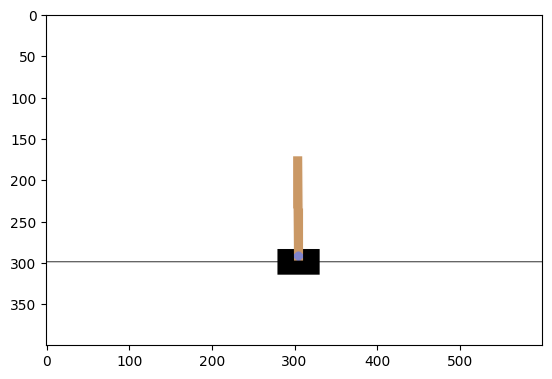

In [5]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

# initialize the environment and obtain the initial state
env.reset()
print("Initial State:", env.reset())

n_actions = env.action_space.n
print("Action Space Dimension:", n_actions)

state_dim = env.observation_space.shape
print("State Space Dimension:", state_dim)

plt.imshow(env.render())

# Build the Policy Network for REINFORCE

In this section, your task is to build a neural network, the policy network, that will predict action probabilities given states. Fill the **< YOUR CODE HERE >** below with your preferred NN architecture. You can refrain from using a deep NN as CartPole-v1 is not worth of deep NN architectures. A shallow NN of one or two hidden layers will be just fine!
> Write an `__init__(...)` function that initializes the network with the given state dimensions and desired output dimensions.

> Write the `forward(...)` function that performs the forward pass of the network

> Write a `get_action(...)` function that takes a batch of states as inputs and uses the policy network to predict action probabilities for each state. Follow those steps in order:
  *   Convert states to PyTorch tensors.
  *   Forward pass through the model to produce logits. Hint: Ensure that the calculation is done without gradient tracking, as it is typically done during inference rather than training. You can stop gradient storing with decorator `@torch.no_grad()`.
  *   Apply softmax to get action probabilities.
  *   Return the resulting action probabilities after converting them back to a NumPy array.

In [26]:
import torch.nn as nn
# Define the neural network for policy
class MLP(nn.Module):
    def __init__(self, state_dim, n_actions, hidden_dim=128):
        super(MLP, self).__init__()
        # Define the architecture
        self.fc1 = nn.Linear(state_dim, hidden_dim)  # First layer
        self.fc2 = nn.Linear(hidden_dim, n_actions)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU non-linearity after first layer
        x = self.fc2(x)  # Output logits
        return x

    @torch.no_grad()  # Decorator to disable gradient calculation
    def get_action(self, state):
        # Ensure state is a 2D array (batch of states)
        state = np.atleast_2d(state)  # This will handle both single and multiple states correctly
        state = torch.tensor(state, dtype=torch.float32)
        logits = self.forward(state)  # Get logits
        probabilities = F.softmax(logits, dim=-1)  # Convert logits to probabilities
        return probabilities.numpy()  # Return as numpy array




Next, instantiate the policy network model

In [27]:
# instantiate the policy network model
model = MLP(state_dim=4, n_actions=2, hidden_dim=128)

After writting your `get_action(...)` function run the cell below to test it.

In [28]:
test_states = np.array([env.reset()[0] for _ in range(5)])
test_probas = model.get_action(test_states)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"
print("all good!")

all good!


# Use the policy network to obtain an episode

Here is a summary of what your code should do:


*   Initialize empty lists of states, actions and rewards to record the trajectory of the episode.
*   Reset the environment and obtain an initial state.
*   Loop over time steps to obtain the episode within a specified maximum number of steps.
> *   Obtain the action probabilities given the current state and the policy network.
> *   Sample an action **from the action probabilities** using `np.random.choice`.
> *   Take a step in the environment with the chosen action and obtain the new state, immediate reward, termination status, truncation status, and additional information. For the meaning of the latter three, please refer to official [Gymnasium Documentation](https://gymnasium.farama.org/api/env/).
> *   Record the current state, action, and reward in the corresponding lists.
> *   Update the current state to the new state.
> *   If the episode is terminated or truncated, exit the loop.
> *   Return the recorded lists of states, actions and rewards for later use.





In [29]:
def rollout_fn(env, model, t_max=500, deterministic=False):
    """
    Obtain an episode with REINFORCE agent.
    Returns sequences of states, actions, and rewards.

    If deterministic is True, the action with the highest probability is selected.
    Otherwise, actions are sampled based on their probabilities.
    """
    # Initialize empty lists for states, actions, and rewards
    states, actions, rewards = [], [], []

    # Reset the environment and obtain the initial state
    state, _ = env.reset()

    for _ in range(t_max):
        # Obtain the action probabilities from the model
        action_probs = model.get_action(state[np.newaxis, :])[0]

        if deterministic:
            # Select the action with the highest probability
            action = np.argmax(action_probs)
        else:
            # Sample an action based on the probabilities
            action = np.random.choice(len(action_probs), p=action_probs)

        # Take the action in the environment
        next_state, reward, done, trunc, _ = env.step(action)

        # Record state, action, and reward
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        # Update the state
        state = next_state

        # Check for episode termination or truncation
        if done or trunc:
            break

    return states, actions, rewards


In the snippet below you can test your function. You can also include some print statements in order to realize the length of a full episode, as well as the specific trajectory of states, actions, and rewards that was played out.

In [30]:
# test it
states, actions, rewards = rollout_fn(env, model)

# Compute returns-to-go

Now, you have to implement a function that returns a list of returns-to-go, where each entry of the list represents the total (discounted) reward you have accumulated up to that time-step in the episode. The prodecure is quite standard although we give some more details below.

In [31]:
def get_returns_to_go(rewards,  # rewards at each step
                      gamma=0.99, # discount for reward
                      normalize=False):
    """
    Take a list of immediate rewards for the whole episode
    and compute returns-to-go

    A simple way to compute returns-to-go is to iterate from the last to the first time-step and compute recurrently

    In some applications returns are normalized by subtracting their mean and dividing by their standard deviation. For this purpose we included the boolean normalize as an arg

    You must return an array/list of returns-to-go with as many elements as in the initial rewards.
    """
    n = len(rewards)
    returns = np.zeros(n)
    for i in range(n):
        for j in range(i, n):
            returns[i] += rewards[j] * (gamma ** (j - i))
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
    return returns

After your implementation execute the code in the following cell and make sure that the statement "looks good" is displayed.

In [32]:
get_returns_to_go(rewards)
assert len(get_returns_to_go(list(range(100)))) == 100
assert np.allclose(
    get_returns_to_go([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_returns_to_go([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_returns_to_go([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


# Objective function and updates over the policy gradient

The policy gradient theorem defines a way to compute the gradient of the objective function with respect to the parameters of the policy network as follows:
$$
\nabla_{\theta} J(\theta)\approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=1}^T G_t^{(i)} \nabla_{\theta} \log \pi_{\theta} (a_t^{(i)}|s_t^{(i)}).
$$
for $N$ episodic trajectories $(\tau^{(i)})_{i=1}^{N}:=\{(s_0^{(i)}, a_0^{(i)}, r_1^{(i)}, s_1^{(i)}, a_1^{(i)}, r_2^{(i)}, ..., s_{T-1}^{(i)}, a_{T-1}^{(i)}, r_{T}^{(i)})\}_{i=1}^{N}$, and corresponding returns-to-go $G_t^{(i)}$.

In the cell below your task is to define the training process of the policy gradient algorithm. Breaking the process down:

*   Optimizer initialization: Initialize an Adam optimizer to update the parameters of the policy network (choose a learning of `1e-03`) and leave all the other Adam parameters as default.
*   Cast states, actions into PyTorch tensors (states take float values, actions take integer values).
*   Use the `get_returns_to_go(...)` function to compute returns-to-go and cast into PyTorch tensors.
*   Use the policy network to predict logits, action probabilities and log-action probabilities. Compute those using operations with torch tensors and **DO NOT** use the `get_action(...)` function instead.
*   Select log-action probabilities for chosen actions.
*   Compute the loss.
*   Perform gradient ascent to update the policy network's parameters.
*   Return the sum of rewards obtained during the duration of an episode.



In [33]:
# define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_step(states, actions, rewards, gamma=0.99):
    """
    Takes a sequence of states, actions and rewards produced by rollout_fn.
    Updates agent's weights by following the policy gradient above.
    """
    # Ensure inputs are PyTorch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64)  # Actions are integers
    returns_to_go = torch.tensor(get_returns_to_go(rewards, gamma), dtype=torch.float32)

    # Reset gradients
    optimizer.zero_grad()

    # Forward pass: get logits for all actions
    logits = model(states)
    log_probs = F.log_softmax(logits, dim=-1)

    # Gather the log probabilities of the actions taken
    actions_log_probs = log_probs[range(len(actions)), actions]

    # Compute the policy gradient loss
    loss = -(returns_to_go * actions_log_probs).mean()

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    return loss.item()

# Training and recording the performance

Plot the training curve averaged over three runs (3 seeds). Each run has a training and a testing phase as described in [5. TD_Methods.pdf](https://brightspace.nyu.edu/d2l/le/lessons/344232/topics/9949410). As a suggestion, for this lab, you might want to try the following:


1.   **Training Phase**: set the model in training mode using `model.train()`.
2.   The agent interacts with the environment for 1000 training episodes, collecting rewards during each episode. During each training episode the model is updated using the policy gradient algorithm implemented on the `train_step(...)` function. Training rewards are collected in a list.
3.   **Testing Phase**: Every 100 episodes the model is switched to evaluation mode using `model.eval()`. At this stage, the agent interacts with the environment for 50 episodes, uses a deterministic strategy by selecting the action with the highest probability, and stores an average of the rewards collected over them.
4.   After the testing phase finishes, the model is switched on to training mode again.



In [34]:
def train_iteration(env, model, n_episodes=1000, test_every=100, n_test_episodes=50, gamma=0.99):
    train_rewards = []
    test_rewards = []

    for episode in range(n_episodes):
        model.train()  # Set model to training mode
        states, actions, rewards = rollout_fn(env, model)
        episode_reward = train_step(states, actions, rewards, gamma)
        train_rewards.append(episode_reward)

        # Testing phase
        if (episode + 1) % test_every == 0:
            model.eval()  # Set model to evaluation mode
            test_episode_rewards = []

            for _ in range(n_test_episodes):
                states, actions, rewards = rollout_fn(env, model, deterministic=True)
                test_episode_rewards.append(sum(rewards))

            average_test_reward = np.mean(test_episode_rewards)
            test_rewards.append(average_test_reward)
            print(f"Episode {episode+1}: Average Test Reward = {average_test_reward}")

    return train_rewards, test_rewards

Episode 100: Average Test Reward = 126.34
Episode 200: Average Test Reward = 282.74
Episode 300: Average Test Reward = 390.52
Episode 400: Average Test Reward = 147.46
Episode 500: Average Test Reward = 333.48
Episode 600: Average Test Reward = 500.0
Episode 700: Average Test Reward = 372.06
Episode 800: Average Test Reward = 485.34
Episode 900: Average Test Reward = 491.9
Episode 1000: Average Test Reward = 500.0
Episode 100: Average Test Reward = 9.36
Episode 200: Average Test Reward = 202.4
Episode 300: Average Test Reward = 163.26
Episode 400: Average Test Reward = 306.22
Episode 500: Average Test Reward = 470.26
Episode 600: Average Test Reward = 500.0
Episode 700: Average Test Reward = 272.34
Episode 800: Average Test Reward = 341.66
Episode 900: Average Test Reward = 175.58
Episode 1000: Average Test Reward = 188.92
Episode 100: Average Test Reward = 80.32
Episode 200: Average Test Reward = 69.32
Episode 300: Average Test Reward = 90.42
Episode 400: Average Test Reward = 413.1
E

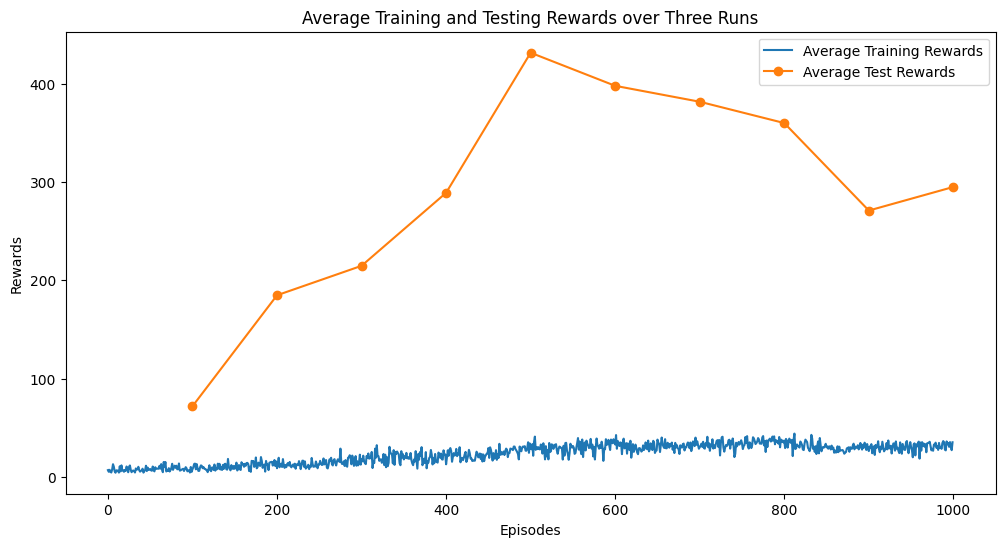

In [36]:
def model_constructor():
    return MLP(state_dim=4, n_actions=2, hidden_dim=128)

def optimizer_constructor(params):
    return torch.optim.Adam(params, lr=1e-3)

# Seed list for running experiments
seeds = [42, 123, 456]

# Initialize lists to store results for averaging
all_train_rewards = []
all_test_rewards = []

# Loop over seeds to perform three separate runs
for seed in seeds:
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Create a new environment instance and model for each run
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    model = model_constructor()
    optimizer = optimizer_constructor(model.parameters())

    # Perform training and testing
    train_rewards, test_rewards = train_iteration(env, model, n_episodes=1000, test_every=100, n_test_episodes=50, gamma=0.99)

    # Store the rewards for later averaging
    all_train_rewards.append(train_rewards)
    all_test_rewards.append(test_rewards)

# Calculate the average rewards across all runs
avg_train_rewards = np.mean(all_train_rewards, axis=0)
avg_test_rewards = np.mean(all_test_rewards, axis=0)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(avg_train_rewards, label='Average Training Rewards')
test_indices = np.arange(100, 1001, 100)
plt.plot(test_indices, avg_test_rewards, 'o-', label='Average Test Rewards')
plt.title('Average Training and Testing Rewards over Three Runs')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()


# PPO: Proximal Policy Optimization

PPO like advanced versions of vanilla Policy gradient, uses a Critic network with parameters $\phi$ and advantage estimate $\hat{A}_t$. You will use the current policy, say $\pi_{\theta_k}$, to generate an episode. When updating $\theta=\theta_k$, you will take several small gradient steps, always using data from $\pi_{\theta_k}$. Similar for the Critic. The gradient update of $\theta$ will approximate the true gradient while maintaining control on the policy ratio $\pi_{\theta}/\pi_{\theta_k}$, i.e. if $\pi_{\theta}$ moves far from $\pi_{\theta_k}$, we clip the loss function so that the gradient is 0 and $\theta$ ceases to change.

## Building the Actor-Critic (A2C) Architecture

In this section, you are going to set up the NN architecture for the actor and critic components of the PPO algorithm. The Actor and the Critic play distinct roles in the learning process.



*   The Actor is used to select actions based on the current policy. The output of the Actor is a probability distribution over all the possible actions in the environment.
*   The Critic provides an estimate for the value function, which represents the expected cumulative reward from a given state, under the current policy. The output of the Critic is a scalar value representing the estimated state value.



In the code cell below build a class that represents the combined architecture for both actor and critic networks in the PPO algorithm:


*   It should take two NNs, `actor` and `critic` as parameters during initialization.
*   `actor` should be in the same fashion as in policy gradient.
*   `critic` should be taking a state as an input and return a scalar that represents the value of that state.
*   It should contain a `forward` method that takes a state as an input and computes the action prediction as well as the value prediction using the actor and critic networks respectively.
*   You should implement `get_action(...)` with `actor` in the same fashion as in policy gradient.

**NOTE:** instantiate the actor and critic networks as two instances of the `MLP` class that you defined in our previous implementation of the policy gradient algorithm. Note that the output dimension of the actor network must be the dimension of the action space while the output dimension of the critic network must be 1.




In [135]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCritic, self).__init__()
        # Actor network
        self.actor = MLP(state_dim, action_dim, hidden_dim)
        # Critic network
        self.critic = MLP(state_dim, 1, hidden_dim)

    def forward(self, state):
        # Get action probabilities
        action_probs = F.softmax(self.actor(state), dim=-1)
        # Get state value
        value = self.critic(state)
        return action_probs, value.squeeze()

    @torch.no_grad()  # Ensure no gradients are calculated for action selection
    def get_action(self, state, action_space=None):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs, _ = self.forward(state)
        action = torch.distributions.Categorical(action_probs).sample()
        return action.item()

In [136]:
a2c_model = ActorCritic(state_dim=4, action_dim=1, hidden_dim=128)

## Compute advantages

The advantage computed at a state-action pair $(S_t, A_t)$ is by definition:
$$ A_{\pi_{\theta}}(S_t, A_t): = Q_{\pi_{\theta}}(S_t,A_t)-V_{\pi_{\theta}}(S_t)\approx G_t-V_{\phi}(S_t):=\hat{A}_t,$$
where as usual $G_t$ is the return-to-go, and $V_{\pi_{\theta}}(s)\approx V_{\phi}(s)$, where $V_{\phi}$ is the output of the `critic` network for an input state $s$. Write a function `get_advantages()` with inputs containing the returns-to-go for each time step and the estimated state values for each time step, and a boolean flag indicating normalization or not, and outputs a tensor containing the advantages.  

In [137]:
def get_advantages(returns_to_go, values, normalize=False):
    # Ensure returns_to_go is a tensor
    if not isinstance(returns_to_go, torch.Tensor):
        returns_to_go = torch.tensor(returns_to_go, dtype=torch.float32)

    # Calculate the advantages
    advantages = returns_to_go - values

    if normalize:
        # Normalize the advantages
        advantages_mean = advantages.mean()
        advantages_std = advantages.std() + 1e-8  # Adding a small value to avoid division by zero
        advantages = (advantages - advantages_mean) / advantages_std

    return advantages


## Update step for PPO

In the next cell, you will implement the PPO algorithm itself. The algorithm replaces the typical policy gradient loss with a surrogate objective that contains the ratio of the new and old policies. Namely, for a single trajectory of length $T$:
$$
J(\theta, \pi_{\theta}, \pi_{\theta_{k}}, \hat{A}_t) = \sum_{t=1}^{T}\frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{k}}(a_t|s_t)} \cdot \hat{A}_t
$$
PPO clipping relies on specialized clipping in the surrogate objective function to remove incentives for the new policy to get away from the old policy. The following equation is known as clipped surrogate objective:
$$
J(\theta, \pi_{\theta}, \pi_{\theta_{k}}, \hat{A}_t, \varepsilon) = \sum_{t=1}^{T} \min\left(\frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{k}}(a_t|s_t)} \cdot \hat{A}_t, \mathrm{clip}\left(
\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)},
1 - \text{ε}, 1 + \text{ε}\right)\cdot \hat{A}_t\right),\\
$$
where $ε$ is a value which defines the clipping neighborhood $\left|\pi_\theta(a_t|s_t)/\pi_{\theta_k}(a_t|s_t)-1\right|<ε$. The first term in the minimum comes directly from the surrogate. The second term bounds the first term between $(1-ε) \hat{A}_t$ and $(1+ε) \hat{A}_t$. When the ratio of the new and the old policy is within the interval $[1-ε,1+ε]$, both terms inside the minimum are equal. This new objective prevents parameter updates which will cause large changes to the old policy. The value loss is computed using the smooth $L_1-$loss between predicted state values and returns-to-go, e.g. [Smooth L1-Loss](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html#torch.nn.SmoothL1Loss).

Fill the < YOUR CODE HERE > below. For a specified number of `ppo_steps`:


*   Given states, use the Actor and Critic to generate predictions for actions and state values.
*   Compute the action probabilities by applying softmax.
*   Compute the new log-probabilities for the taken actions under the updated policy.
*   Compute the PPO clipped surrogate objective and the value loss.
*   Backpropagate separately for the two losses.
*   Accumulate total losses over `ppo_steps`.
*   Return average policy and value losses.


In [138]:
from torch.distributions import Categorical
import torch.distributions as distributions

def train_step_ppo(a2c_model, states, actions, log_prob_actions, advantages, returns_to_go, optimizer, ppo_steps, ppo_clip):
  total_policy_loss = 0
  total_value_loss = 0

  # detach advantages, actions, log_prob_actions
  advantages = advantages.detach()
  actions = actions.detach()
  log_prob_actions = log_prob_actions.detach()

  for _ in range(ppo_steps): # Loop over several small gradient steps, always using the data from the current policy
     action_pred, value_pred = a2c_model(states) # pass the input states through the A2C model
     value_pred = value_pred.squeeze(-1)
     action_prob = F.softmax(action_pred, dim=-1) # pass action_pred through softmax to compute action probabilities
     dist = distributions.Categorical(action_prob)

     new_log_prob_actions = dist.log_prob(actions) # new log-probs using old actions

     policy_ratio = (new_log_prob_actions - log_prob_actions).exp()

     policy_loss_1 = policy_ratio * advantages # left-hand side in the min of the clipped objective
     policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages # right-hand side in the min of the clipped objective

     policy_loss = - torch.min(policy_loss_1, policy_loss_2).sum() # clipped objective

     value_loss = F.smooth_l1_loss(returns_to_go, value_pred).sum() # fit value function by minimizing smooth L1-loss

     optimizer.zero_grad() # zero out gradients

     policy_loss.backward() # back-propagate on the policy_loss
     value_loss.backward() # back-propagate on the value_loss

     optimizer.step() # take a gradient step

     total_policy_loss += policy_loss.item()
     total_value_loss += value_loss.item()

  return total_policy_loss/ppo_steps, total_value_loss/ppo_steps

## Training

Time to train!


*   Initialize your model to training mode. You will store states, actions, action log-probabilities, state values, immediate rewards, and accumulated episodic reward.
*   Enter a loop that interacts with the environment until the episode is done.

> * Use the A2C model to get action predictions and state value predictions for the current state.

> *   Sample an action from the predicted action probabilities and record the log-probability of the sampled action. Take a step in the environment to generate a new state, immediate reward and done flag, see [official documentation](https://gymnasium.farama.org/api/env/) on how to do this.

> *  Append action, log-probability of the action, state value prediction, and reward to the respective lists. Accumulate episodic reward.

*  After exiting the loop, calculate returns-to-go, advantages, and use the `train_step(...)` to calculate policy and value losses.

*  Return policy loss, value loss and accumulated episodic reward.



In [139]:
def train_iteration_ppo(env, a2c_model, optimizer, discount_factor, ppo_steps, ppo_clip):
    # Set model to training mode
    a2c_model.train()

    # Initialize lists to store states, actions, log_probs, values, rewards
    states, actions, log_probs, values, rewards = [], [], [], [], []
    state = env.reset()  # Reset environment and get initial state
    done = False
    accumulated_reward = 0

    # Collect data from one episode
    while not done:
        # Convert state into a tensor and get action and value predictions
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action_probs, value_pred = a2c_model(state_tensor)

        # Sample action from the action probabilities
        dist = Categorical(action_probs)
        action = dist.sample()

        # Take action in the environment
        next_state, reward, done, truncated = env.step(action.item())

        # Store data
        states.append(state_tensor)
        actions.append(action)
        log_probs.append(dist.log_prob(action))
        values.append(value_pred)
        rewards.append(reward)

        # Update state and accumulated reward
        state = next_state
        accumulated_reward += reward

    # Convert lists to tensors
    states = torch.cat(states)
    actions = torch.cat(actions)
    log_probs = torch.cat(log_probs).detach()
    returns_to_go = torch.tensor(get_returns_to_go(rewards, discount_factor), dtype=torch.float32)

    # Ensure values are at least 1-dimensional before concatenation
    values_tensors = [v.unsqueeze(0) for v in values]  # Unsqueezes each tensor
    concatenated_values = torch.cat(values_tensors)

    # Calculate advantages
    advantages = get_advantages(returns_to_go, concatenated_values.squeeze(-1), normalize=True)

    # Perform PPO update
    total_policy_loss, total_value_loss = train_step_ppo(a2c_model, states, actions, log_probs, advantages, returns_to_go, optimizer, ppo_steps, ppo_clip)

    return total_policy_loss, total_value_loss, accumulated_reward

## Inference/Evaluation

To evaluate the model in the given environment, we need to introduce a function to assess the performance of the trained model in a given environment without updating the model's parameters. In summary, this function evaluates the model in the given environment using a deterministic strategy (selecting the action with the highest probability) and returns the total reward obtained during the evaluation episode.
Hint: you will only be needing the `actor` network in `a2c_model` in this case. Make sure to utilize the `get_action(...)` function.

In [140]:
def evaluate(env, a2c_model):
    # Set model to evaluation mode
    a2c_model.eval()

    state = env.reset()  # Reset environment and get initial state
    done = False
    total_reward = 0

    # Interact with the environment until the episode is done
    while not done:
        with torch.no_grad():  # No need to track gradients during evaluation
            # Convert state into a tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            # Use the actor network to get action predictions
            # Since we are evaluating, we choose the action with the highest probability (deterministic policy)
            action_probs, _ = a2c_model(state_tensor)
            action = torch.argmax(action_probs).item()

            # Take action in the environment
            next_state, reward, done, truncated = env.step(action)

            # Update state and total reward
            state = next_state
            total_reward += reward

    return total_reward

## Training and recording the performance of PPO

Train and record performance in a similar fashion with vanilla policy gradient. Here, you can try at most 500 interactions with the environment. For every episode have a training phase followed by a testing phase.

In [141]:
def train_and_test_ppo(n_episodes=500, test_every=100, n_test_episodes=50, gamma=0.99, seeds=[42, 123, 456]):
    all_train_rewards = []
    all_test_rewards = []

    for seed in seeds:
        np.random.seed(seed)
        torch.manual_seed(seed)

        env = gym.make('CartPole-v1')

        model = ActorCritic(state_dim=env.observation_space.shape[0], action_dim=env.action_space.n)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        train_rewards = []
        test_rewards = []

        for episode in range(n_episodes):
            # Training Phase
            model.train()
            policy_loss, value_loss, episode_reward = train_iteration_ppo(env, model, optimizer, discount_factor=gamma, ppo_steps=10, ppo_clip=0.3)
            train_rewards.append(episode_reward)

            # Testing Phase
            if (episode + 1) % test_every == 0:
                model.eval()
                test_episode_rewards = [evaluate(env, model) for _ in range(n_test_episodes)]
                average_test_reward = np.mean(test_episode_rewards)
                test_rewards.append(average_test_reward)
                print(f"Seed {seed}, Episode {episode+1}: Average Test Reward = {average_test_reward}")

        all_train_rewards.append(train_rewards)
        all_test_rewards.append(test_rewards)

    # Averaging the rewards across all runs
    avg_train_rewards = np.mean(all_train_rewards, axis=0)
    avg_test_rewards = np.mean(all_test_rewards, axis=0)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(avg_train_rewards, label='Average Training Rewards')
    test_indices = np.arange(test_every, n_episodes+1, test_every)
    plt.plot(test_indices, avg_test_rewards, 'o-', label='Average Test Rewards')
    plt.title('PPO Training and Testing Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()
    plt.show()


Seed 42, Episode 100: Average Test Reward = 170.02
Seed 42, Episode 200: Average Test Reward = 264.74
Seed 42, Episode 300: Average Test Reward = 500.0
Seed 42, Episode 400: Average Test Reward = 456.4
Seed 42, Episode 500: Average Test Reward = 500.0
Seed 123, Episode 100: Average Test Reward = 9.4
Seed 123, Episode 200: Average Test Reward = 171.46
Seed 123, Episode 300: Average Test Reward = 308.46
Seed 123, Episode 400: Average Test Reward = 436.98
Seed 123, Episode 500: Average Test Reward = 500.0
Seed 456, Episode 100: Average Test Reward = 34.98
Seed 456, Episode 200: Average Test Reward = 50.64
Seed 456, Episode 300: Average Test Reward = 76.16
Seed 456, Episode 400: Average Test Reward = 63.98
Seed 456, Episode 500: Average Test Reward = 71.48


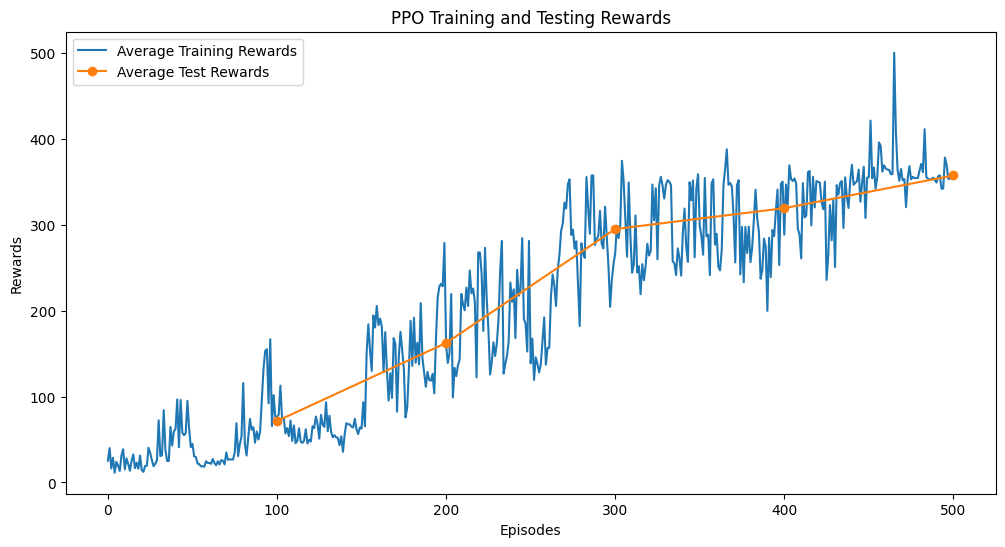

In [144]:
train_and_test_ppo()

# BONUS

Modify policy gradient in creative ways to improve its performance. Some things you can try are adding entropy bonus, modifying hyper parameters, normalizing returns-to-go and advantages, etc.

In [ ]:
def entropy_reg(probs, log_probs, entropy_coef=1e-02):
  """
  Takes tensors of probabilities and corresponding log-probabilities and returns the entropy multiplied by entropy_coef
  """
  return -entropy_coef * torch.sum(probs * log_probs)